In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

### Load/Preprocess Customer Churn Training Datasets ###

In [2]:
# Load 'customer_churn_training' Into Pandas DataFrame
conn=sqlite3.connect('Resources/customer_churn_data.db')
query = "SELECT * FROM customer_churn_complete"
customer_churn_complete = pd.read_sql(query, conn)
conn.close()

# Check That 'customer_churn_training' Loaded Succesfully
customer_churn_complete.head()

,age,female,male,tenure,basic_subscription,standard_subscription,premium_subscription,monthly_contract,quarterly_contract,annual_contract,total_spend,payment_delay,usage_frequency,last_interaction,support_calls,churn
0,30.0,1.0,0.0,39.0,0.0,1.0,0.0,0.0,0.0,1.0,932.0,18.0,14.0,17.0,5.0,1.0
1,65.0,1.0,0.0,49.0,1.0,0.0,0.0,1.0,0.0,0.0,557.0,8.0,1.0,6.0,10.0,1.0
2,55.0,1.0,0.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,185.0,18.0,4.0,3.0,6.0,1.0
3,58.0,0.0,1.0,38.0,0.0,1.0,0.0,1.0,0.0,0.0,396.0,7.0,21.0,29.0,7.0,1.0
4,23.0,0.0,1.0,32.0,1.0,0.0,0.0,1.0,0.0,0.0,617.0,8.0,20.0,20.0,5.0,1.0


In [3]:
# Define Features Set
X = customer_churn_complete.drop(columns=['churn'])

# Define Target
y = customer_churn_complete['churn']

# Split Into Train And Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, stratify=y)

In [4]:
# Create StandardScaler Instance
scaler = StandardScaler()

# Fit Standard Scaler
X_scaler = scaler.fit(X_train)

# Scale Training And Testing Data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled)
X_train_scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-1.003381,1.115437,-1.115437,-0.947490,1.440753,-0.714332,-0.712967,-0.525262,1.248400,-0.804484,-0.315676,-1.478292,0.033855,-0.883825,-0.585243
1,-1.319131,1.115437,-1.115437,-0.367163,1.440753,-0.714332,-0.712967,-0.525262,-0.801025,1.243033,1.541560,0.532709,1.658720,-0.302919,-0.585243
2,0.654306,-0.896510,0.896510,-0.193065,1.440753,-0.714332,-0.712967,1.903813,-0.801025,-0.804484,0.745311,1.833945,-0.198268,-0.302919,1.647099
3,0.338556,-0.896510,0.896510,0.735458,-0.694082,1.399910,-0.712967,1.903813,-0.801025,-0.804484,0.194626,1.360768,0.614164,-0.651463,0.371475
4,0.417493,-0.896510,0.896510,0.039066,-0.694082,1.399910,-0.712967,-0.525262,-0.801025,1.243033,0.717613,0.059532,-0.778577,1.091258,-0.266337


### Fit Random Forest Model ###

In [5]:
# Create Random Forest Classifier
rf_model = RandomForestClassifier(random_state=5)

# Fit The Model
rf_model = rf_model.fit(X_train_scaled, y_train)

### Make Predictions Using the Random Forest Model ###

In [6]:
# Make Predictions Using The Testing Data
predictions = rf_model.predict(X_test_scaled)

### Model Evaluation: Confusion Matrix and Classification Report ###

In [7]:
# Calculate The Confusion Matrix
confusion_matrix = confusion_matrix(y_test, predictions)
confusion_matrix_df = pd.DataFrame(confusion_matrix,
                                   index=['Actual 0', 'Actual 1'],
                                   columns=['Predicted 0', 'Predicted 1'])

# Calculate The Accuracy Score
accuracy_score_confusion_matrix = accuracy_score(y_test, predictions)

# Display Results
print('Confusion Matrix')
display(confusion_matrix_df)
print(f'Accuracy Score : {accuracy_score_confusion_matrix}')
print('\nClassification Report')
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,48266,7913
Actual 1,252,69871


Accuracy Score : 0.935353359408402

Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92     56179
         1.0       0.90      1.00      0.94     70123

    accuracy                           0.94    126302
   macro avg       0.95      0.93      0.93    126302
weighted avg       0.94      0.94      0.93    126302



Based on the Confusion Matrix:
  - 56179 staying customers: 48266 correctly predicted and 7913 incorrectly predicted
  - 70123 churned customers: 69871 correctly predicted and 252 incorrectly predicted

Based on the Classification Report:
  1. Precision:
      - model correctly predicts customer to: stay 99% of the time, churn 90% of the time
  2. Recall:
      - model correctly identifies: 86% of all staying customers, 100% of churned customers
  3. F1-Score:
      - balance between precision and recall
  4. Support:
      - 56179 staying customers 70123 churned customers in the dataset

In summary:
  - The model has high precision, recall, and F1-score for both classes, indicating good overall performance

### Feature Importance ###

In [8]:
# Sort Features By Importance
importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.262759340709975, 'support_calls'),
 (0.1786445367578004, 'total_spend'),
 (0.1425905690560615, 'payment_delay'),
 (0.12818447604263894, 'age'),
 (0.0694819729318956, 'last_interaction'),
 (0.06578445340998139, 'monthly_contract'),
 (0.0431935233282975, 'tenure'),
 (0.0330395213356618, 'usage_frequency'),
 (0.02054205916249044, 'annual_contract'),
 (0.017928920504622546, 'quarterly_contract'),
 (0.015775301848203797, 'male'),
 (0.012766593339895218, 'female'),
 (0.0033795304641979, 'basic_subscription'),
 (0.0029677654900235407, 'premium_subscription'),
 (0.002961435618254536, 'standard_subscription')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

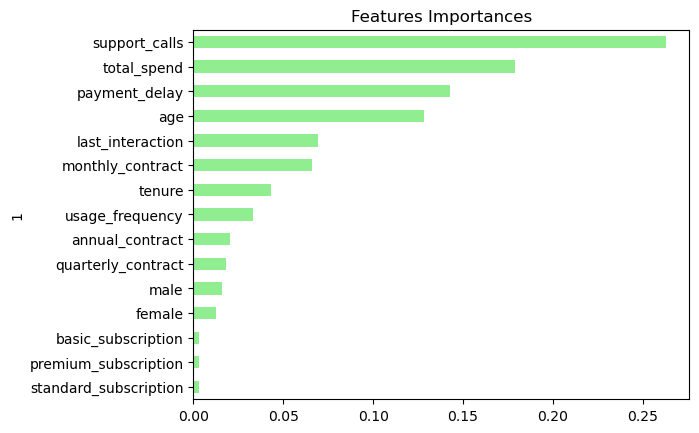

In [9]:
# Visualize The Features By Importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

### Model Evaluation: Cross-Validation ###

In [10]:
# Establish Cross-Validation DataFrame Along With Features And Target Column Names
customer_churn_cross_validation = customer_churn_complete.copy()
feature_columns = customer_churn_cross_validation.columns.drop('churn')
target_column = 'churn'

# Initialize KFold Cross-Validation
kf = KFold(n_splits=20, shuffle=True, random_state=5)

# Initialize List To Store Cross-Validation Scores
cross_validation_accuracy_scores = []
cross_validation_f1_scores = []

# Perform Cross-Validation
for train_index, test_index in kf.split(customer_churn_cross_validation):
    X_train, X_test = customer_churn_cross_validation[feature_columns].iloc[train_index], customer_churn_cross_validation[feature_columns].iloc[test_index]
    y_train, y_test = customer_churn_cross_validation[target_column].iloc[train_index], customer_churn_cross_validation[target_column].iloc[test_index]
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cross_validation_accuracy_scores.append(accuracy)
    f1_scores = f1_score(y_test, y_pred)
    cross_validation_f1_scores.append(f1_scores)

# Calculate Mean And Standard Deviation Of Cross-Validation Accuracy Scores
mean_accuracy = np.mean(cross_validation_accuracy_scores)
standard_deviation_accuracy = np.std(cross_validation_accuracy_scores)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", standard_deviation_accuracy)

# Calculate Mean And Standard Deviation Of Cross-Validation F1 Scores
mean_f1_scores = np.mean(cross_validation_f1_scores)
standard_deviation_f1_scores = np.std(cross_validation_f1_scores)
print("\nMean F1 Score:", mean_f1_scores)
print("Standard Deviation of F1 Score:", standard_deviation_f1_scores)

Mean Accuracy: 0.935459991982985
Standard Deviation of Accuracy: 0.0014014952260578862

Mean F1 Score: 0.9449233464865401
Standard Deviation of F1 Score: 0.0011500458828311766


Based on the Cross-Validation Report:
  - model's performance evaluated across multiple subsets of the data, providing a more reliable estimate of its generalization ability
  - model performs consistently across different data partitions